## Binary Image classification - Beagle vs others dogs breeds 
#### Author: Andreia Sousa 200902629


Sources Images dogs: 
- https://www.robots.ox.ac.uk/~vgg/data/pets/
- https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
- https://pixabay.com/images/search/beagle/?pagi=3&
- https://www.istockphoto.com/pt/search/2/image?page=33&phrase=beagle
  

In [18]:
# Import Libraries:

from collections import defaultdict
import copy
import random
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import time

1. Load Data

In [19]:
dataset_directory = os.path.join(os.environ["HOME"], "projects_andreiapfsousa/ComputerVisionProjects/Breeds_project")

2. Split data in Train, val and test datasets

In [20]:
root_directory = os.path.join(dataset_directory, "Dog_images_beagle")

beagle_directory = os.path.join(root_directory, "beagle")
others_directory = os.path.join(root_directory, "others")

beagle_images_filepaths = sorted([os.path.join(beagle_directory, f) for f in os.listdir(beagle_directory)])
others_images_filepaths = sorted([os.path.join(others_directory, f) for f in os.listdir(others_directory)])
images_filepaths = [*beagle_images_filepaths, *others_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:1600]
val_images_filepaths = correct_images_filepaths[1600:-200]
test_images_filepaths = correct_images_filepaths[-200:]

print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

1600 203 200


##### Visualize images function:

In [21]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    correct_labels=[]
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        if true_label == predicted_label:
            correct_labels.append(predicted_label)
            
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    print("correct_labels:", len(correct_labels))

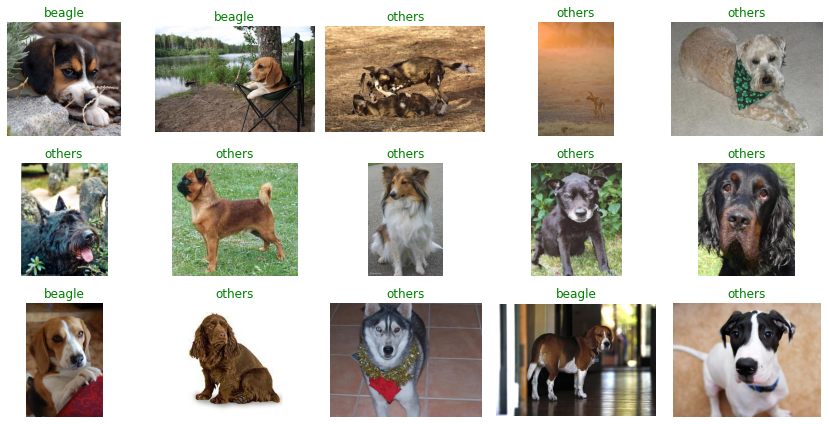

correct_labels: 15


In [22]:
display_image_grid(test_images_filepaths[:15])

In [23]:
class beagleVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "beagle":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

3. Data augmentation pipelines:

3.1 General Experiment:

In [24]:
train_transform = A.Compose(
    [
        A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = beagleVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

3.2 Data Augmentation Experiment:

In [25]:
train_transform = A.Compose(
    [
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=4, p=0.3),
        ], p=0.3),
        A.VerticalFlip(p=0.3), 
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.GaussNoise(),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.6),
        A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = beagleVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [26]:
val_transform = A.Compose(
    [
        A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = beagleVsDogsDataset(images_filepaths=train_images_filepaths, transform=val_transform)

##### Visualize augmentations:

In [27]:
def visualize_augmentations(dataset, idx=85, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

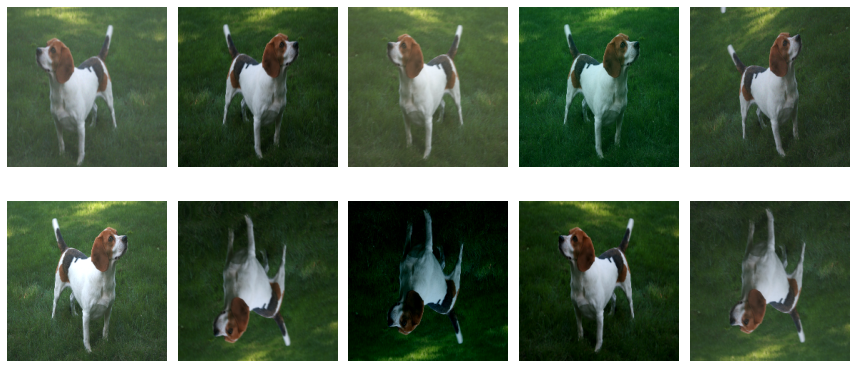

In [28]:
random.seed(42)
visualize_augmentations(train_dataset)

4. Define Metrics functions: Accuracy and Metric monitor

In [29]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [30]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

5. Define Model and parameters

5.1 Experiments with Pre-trained model-REsNet50:

In [37]:
params = {
    "model": "resnet50",
    "device": "cpu",
    "lr": 0.001,
    "batch_size": 32,
    "epochs": 20
}

ResNet Pre-trained model (with transfer learning):

- ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.
(source: https://www.mathworks.com/help/deeplearning/ref/resnet50.html;jsessionid=4e3cfadbacf460efa3189b222509)

In [32]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 1)

model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

5.2 Experiments from Scracth(without transfer learning) with simple Neural Network:

In [33]:
params = {
    "device": "cpu",
    "epochs": 20
}

In [34]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()      
        self.model = nn.Sequential(
        # First 2D convolutional layer, taking in 3 input channel (image),
        # outputting 32 convolutional features, with a square kernel size of 3
        nn.Conv2d(3, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        #Rectified Linear Unit (ReLU) -  an activation function that is defined as this: relu(x) = { 0 if x<0, x if x > 0}. 
        #The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.
        #The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better 
        nn.ReLU(),
        #nn. BatchNorm2d is the number of dimensions/channels(32)that output from the last layer and come in to the batch norm layer.
        nn.BatchNorm2d(num_features=32),
        # corners detector, smoothing the images
        nn.MaxPool2d(kernel_size=(2,2)), # kernel size
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        #Rectified Linear Unit (ReLU)
        nn.ReLU(),
        #nn. BatchNorm2d is the number of dimensions/channels(64) that output from the last layer and come in to the batch norm layer.
        nn.BatchNorm2d(num_features=64),
        # corners detector, smoothing the images
        nn.MaxPool2d(kernel_size=(2,2)), # kernel size
        #flatten() always returns an 1D tensor as result, provided that the input is at least 1D or greater, whereas nn. Flatten() always returns a 2D tensor, provided that the input is at least 2D or greater.
        nn.Flatten(),
        # First fully connected layer
        nn.Linear(in_features=200704, out_features=512),
        # Second fully connected layer that outputs our 1 labels (Binary Problem)
        nn.Linear(in_features=512, out_features=1)
        )    


    def forward(self, x):
        x = self.model(x)
        return x

In [35]:
model = BinaryClassification()
model = model.to(params["device"])
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

BinaryClassification(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=200704, out_features=512, bias=True)
    (10): Linear(in_features=512, out_features=1, bias=True)
  )
)


6. Run train and validation:

In [38]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True,
)

In [39]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    since = time.time()
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)

    
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )


In [40]:
def validate(val_loader, model, criterion, epoch, params):
    since = time.time()
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)

    
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [43]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 141.481 | Accuracy: 0.535: 100%|██████████| 50/50 [02:17<00:00,  2.76s/it]
Epoch: 1. Validation. Loss: 35.481 | Accuracy: 0.544: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]
Epoch: 2. Train.      Loss: 16.539 | Accuracy: 0.573: 100%|██████████| 50/50 [02:28<00:00,  2.97s/it]
Epoch: 2. Validation. Loss: 12.395 | Accuracy: 0.526: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s]
Epoch: 3. Train.      Loss: 20.784 | Accuracy: 0.580: 100%|██████████| 50/50 [02:23<00:00,  2.87s/it]
Epoch: 3. Validation. Loss: 12.336 | Accuracy: 0.588: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s]
Epoch: 4. Train.      Loss: 26.871 | Accuracy: 0.566: 100%|██████████| 50/50 [02:35<00:00,  3.10s/it]
Epoch: 4. Validation. Loss: 10.100 | Accuracy: 0.683: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s]
Epoch: 5. Train.      Loss: 14.730 | Accuracy: 0.600: 100%|██████████| 50/50 [02:35<00:00,  3.10s/it]
Epoch: 5. Validation. Loss: 10.601 | Accuracy: 0.594: 100%|██████████| 50/50 [00:

7. Inference

In [44]:
class beagleVsDogsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = beagleVsDogsInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False,  pin_memory=True,
)

In [45]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.8)[:, 0].cpu().numpy()
        predicted_labels += ["beagle" if beagle else "others" for beagle in predictions]

/var/folders/jt/3qvb06sx5vqbk5jw9f8kycjw0000gn/T/ipykernel_6211/3332341001.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


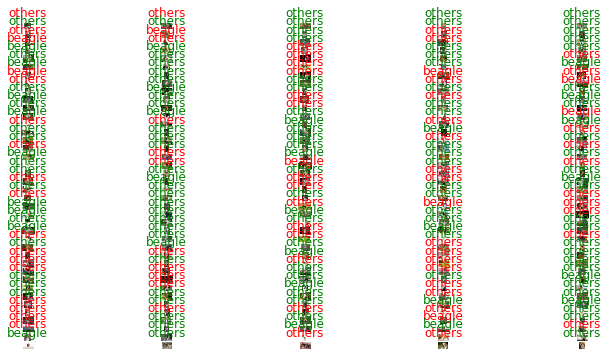

correct_labels: 126


In [46]:
display_image_grid(test_images_filepaths, predicted_labels)

In [49]:

print("Accuracy test dataset:",(126/200)*100)

Accuracy test dataset: 63.0


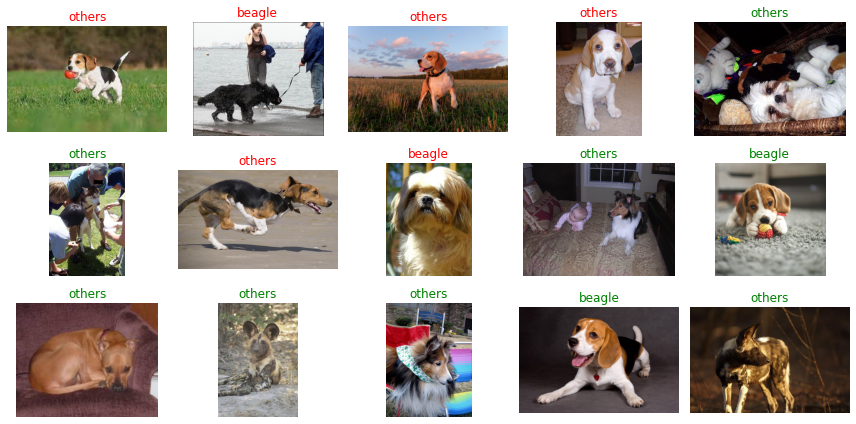

correct_labels: 9


In [48]:
display_image_grid(test_images_filepaths[37:52], predicted_labels[37:52])